In [1]:
import pybamm
import pandas as pd
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt

## Generate synthetic data

We can do this once outside the optimization loop

In [2]:
# Load model
model = pybamm.lithium_ion.SPM()

# Load parameters and set the particle diffusivities
params_for_data = pybamm.ParameterValues("Chen2020")
params_for_data.update(
    {
        "Negative particle diffusivity [m2.s-1]": 5e-14,
        "Positive particle diffusivity [m2.s-1]": 8e-14,
    }
)

# Define experiment
experiment = pybamm.Experiment(["Discharge at 1C until 3.3 V"])

# Run simulation
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=params_for_data)
sim.solve()

# Get solution
solution = sim.solution

# Store "data" in a dataframe. Here we extract the time, current and voltage from the solution.
data = pd.DataFrame(
    {k: solution[k].data for k in ["Time [s]", "Current [A]", "Voltage [V]"]}
)

# Print the first 5 rows
data.head()

,Time [s],Current [A],Voltage [V]
0,0.0,5.0,4.063401
1,60.0,5.0,4.032425
2,120.0,5.0,4.014699
3,180.0,5.0,4.002719
4,240.0,5.0,3.996015


## Set up the parameter estimation

In PyBaMM, we can use `InputParameters` to set the values of the parameters that we want to estimate at the time of solve, rather than recreating the simulation object inside the objective function. Creating a simulation is expensive. Input parameters let us reuse the same simulation object for multiple solves.

In [3]:
# Make a copy of the parameters
params_for_estimation = params_for_data.copy()
# Set the diffusivities to be InputParameters
params_for_estimation.update(
    {
        "Negative electrode diffusivity [m2.s-1]": pybamm.InputParameter("D_neg"),
        "Positive electrode diffusivity [m2.s-1]": pybamm.InputParameter("D_pos"),
    }
)

# Create a simulation object using the same model and experiment as before
sim = pybamm.Simulation(
    model, experiment=experiment, parameter_values=params_for_estimation
)

Next we set up the objective function. We want to minimize the sum of the squared differences between the data and the simulation. We need to make sure we evaluate the solution inside the objective function at the same time points as the data. We also want to catch any errors that occur during the simulation, such as a failure to converge.

In [4]:
t_data = data["Time [s]"].values
V_data = data["Voltage [V]"].values


def objective_function(x):
    # Wrap the solve in a try-except block to catch any errors
    try:
        # Pass the inputs to the simulation at solve time
        sol = sim.solve(inputs={"D_neg": x[0], "D_pos": x[1]})

        # Compute the voltage at the data time points
        V_sim = sol["Voltage [V]"](t_data)

        # Return the differences between the data and the simulation
        return V_sim - V_data
    except pybamm.SolverError:
        # Return a large value if the solver fails
        return np.inf


# Set up the optimization with the initial guesses and bounds
result = least_squares(
    objective_function, x0=[1e-14, 2e-14], bounds=([1e-14, 1e-14], [1e-12, 1e-12])
)
x_fit = result.x

# Print the result
x_true = [
    params_for_data["Negative electrode diffusivity [m2.s-1]"],
    params_for_data["Positive electrode diffusivity [m2.s-1]"],
]

print("x_fit: ", x_fit)
print("x_true: ", x_true)

x_fit:  [5.00396346e-14 7.99773302e-14]
x_true:  [5e-14, 8e-14]


# Finally we plot the model vs "data"

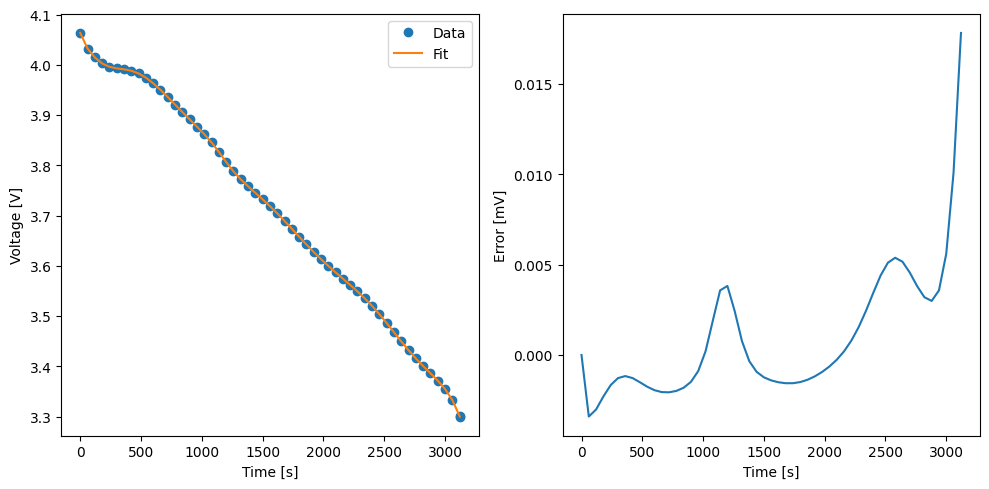

In [5]:
sol_fit = sim.solve(inputs={"D_neg": x_fit[0], "D_pos": x_fit[1]})
V_fit = sol_fit["Voltage [V]"](t_data)

error_mV = (V_fit - V_data) * 1000

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t_data, V_data, "o", label="Data")
ax[0].plot(t_data, V_fit, label="Fit")
ax[0].legend()
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Voltage [V]")
ax[1].plot(t_data, error_mV, label="Error")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Error [mV]")
plt.tight_layout()